## Hyperparameter search

Source: https://github.com/itdxer/neupy/blob/master/notebooks/Hyperparameter%20optimization%20for%20Neural%20Networks.ipynb
and http://neupy.com/2016/12/17/hyperparameter_optimization_for_neural_networks.html#id14

```python
Hyperparams to train:
1. lamda
2. number of hidden layers
3. number of hidden units
3. starter learning rate
5. use_sigmoid_h1
6. use_sigmoid_h2```

In [1]:
import time
import os
import sys
sys.path = sys.path[1:]
sys.path.insert(0, os.path.join(os.getcwd(), "helper_scripts"))  # pretending we are running main.py in jupyter

from global_variables_final_for_git import Global_Vars
from prep_for_model_for_git import Model_preparation

import hyperopt
from hyperopt import fmin
import HPO_helper
reload(HPO_helper)
from HPO_helper import uniform_int, loguniform_int, tpe_method, get_parameter_space_forHPO
import tensorflow_model_for_git
reload(tensorflow_model_for_git)
from tensorflow_model_for_git import Tensorflow_model

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
class Args(object):
    def __init__(self):
        self.gene = "NANOG"
        self.distance = 200
        self.use_tad_info = True
        self.pcc_lowerlimit_to_filter_dhss = 0.25
        self.take_log2_tpm = True
        self.filter_tfs_by = "zscore" # or "pcc"
        self.lowerlimit_to_filter_tfs = 4.75
        self.take_this_many_top_fts = 15  # all dhss/tfs will already be filtered by pcc(or zscore)
        self.init_wts_type = "corr"
        self.outputDir = "/Users/Dinesh/Dropbox/Github/predicting_gex_with_nn_git/Output/"+self.gene.upper()
        self.use_random_DHSs = True
        self.use_random_TFs = True
        self.max_iter = 300

start_time = time.time()
args = Args()
gv = Global_Vars(args, args.outputDir)  # note this takes in new_output_dir as well in .py scripts
mp = Model_preparation(gv)

2018-01-22 10:33:50,321: global_variables_final_for_git: INFO    : Setting up the DNase-seq dataframe and gene expression vector..
2018-01-22 10:34:00,733: global_variables_final_for_git: INFO    : Done. Setting up the training and testing split..
2018-01-22 10:34:00,741: prep_for_model_for_git: INFO    : Preparing the dataframe for train/test splits..


lamda:0.3, layer_sizes:[10]
lamda:0.03, layer_sizes:[18]
lamda:0.03, layer_sizes:[14]
lamda:0.03, layer_sizes:[13, 12]
lamda:3e-05, layer_sizes:[16]
lamda:3e-07, layer_sizes:[19, 6]
lamda:0.0003, layer_sizes:[19]
lamda:3e-07, layer_sizes:[19]
lamda:3e-05, layer_sizes:[9, 12]
lamda:0.3, layer_sizes:[9]


NameError: name 'np' is not defined

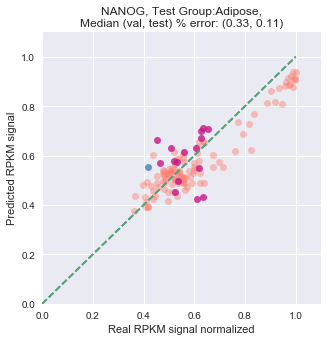

In [3]:
'''Run HPO on differen train/test splits'''
for test_idx in range(0, 1):
    # test_idx = 6  # 5 corresponds to ES_deriv group
    if (test_idx == 4):  # corresponds to val_group of "ENCODE2012"
        continue
    tm = Tensorflow_model(gv, mp, test_eid_group_index=test_idx)
    trials = hyperopt.Trials()

    best_params = hyperopt.fmin(tm.train_tensorflow_nn, trials=trials, space=get_parameter_space_forHPO(tm.trainX),
                                algo=tpe_method, max_evals=10) 

    med_pc_test_error, med_pc_val_error = tm.plot_scatter_performance(trials, gv, index=None)
    med_val_pcc = trials.results[np.argmin(trials.losses())]["val_pcc"].flatten()[-1]
    logger.info("trainX.shape:{}, testX.shape:{}".format(tm.trainX.shape, tm.testX.shape))
    logger.info("Test Group {}: {},\
                Median Test pc Error: {},\
                Median Val (pc error, pcc): ({},{})\
                Best Params: {}".format(
        tm.test_eid_group_index, tm.test_eid_group,
        round(med_pc_test_error, 3),
        round(med_pc_val_error, 3), round(med_val_pcc, 3),
        best_params))
    del tm, trials, best_params

print("Total time taken: {}".format(time.time() - start_time))

# DeepLIFT implementation

trial_idx = 1
plt.plot(trials.results[trial_idx]['train_loss'], color="salmon")
plt.plot(trials.results[trial_idx]['val_loss'], color="mediumvioletred")

In [ ]:
# - EOF - 